In [ ]:
!pip install pydicom

In [ ]:
import os
import random
import math
import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm
import glob
from PIL import Image, ImageDraw
import cv2
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms.functional as F
from torchvision import datasets, models, transforms

from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Part 1. Convolutional neural network

In [ ]:
def get_transform(target_size):
    transform = []
    transform.append(transforms.ToTensor())
    transform.append(transforms.Resize(target_size))
    return transforms.Compose(transform)

In [ ]:
class TrainData(Dataset):
    def __init__(self, all_paths, target_size=(512, 512)):
        self.all_paths = all_paths
        self.class_mapper = {'FLAIR':0, 'T1w':1, 'T1wCE':2, 'T2w':3}
        self.target_size = target_size

    def __len__(self) -> int:
        return len(self.all_paths)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.all_paths[idx]
        dicom = pydicom.read_file(img_name)
        image = dicom.pixel_array
        image = np.repeat(image[..., np.newaxis], 3, -1)
        image = image.astype(int)

        preprocess = get_transform(self.target_size)
        image = preprocess(image)
        
        name = img_name.split('/')[-2]
        target = self.class_mapper[name]
        labels = torch.tensor(target)

        sample = {'image': image, 'label': labels, 'path': img_name}

        return sample

In [ ]:
with open('train_paths.json', 'r') as f:
    images_train = json.load(f)
with open('test_paths.json', 'r') as f:
    images_test = json.load(f)

images_train = [x[0] for x in images_train]
images_test = [x[0] for x in images_test]

In [ ]:
batch_size = 16
train_dataset = TrainData(images_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TrainData(images_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
batch_in_epoch = len(train_dataset) / batch_size

def plot_progress(train_losses, train_accs, test_losses, test_accs):
    clear_output(True)
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    f.set_figheight(6)
    f.set_figwidth(20)

    train_losses_show = train_losses.copy()
    test_losses_show = test_losses.copy()

    if len(train_losses) > 100:
        train_losses_show = train_losses_show[50:]
        test_losses_show = test_losses_show[50:]
    
    ax1.plot(train_losses_show, label='train loss')
    ax1.plot(test_losses_show, label='val loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()
    
    ax2.plot(train_accs, label='train acc')
    ax2.plot(test_accs, label='val acc')
    ax2.plot(np.ones_like(train_accs), '--', label='100% accuracy')
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Batch number')
    ax2.legend()
    for i in range(int(len(train_accs) // batch_in_epoch)):
        ax2.axvline(x = i * batch_in_epoch)

    plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = models.efficientnet_b0(pretrained=False) 

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 4)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, betas=(0.9, 0.999))

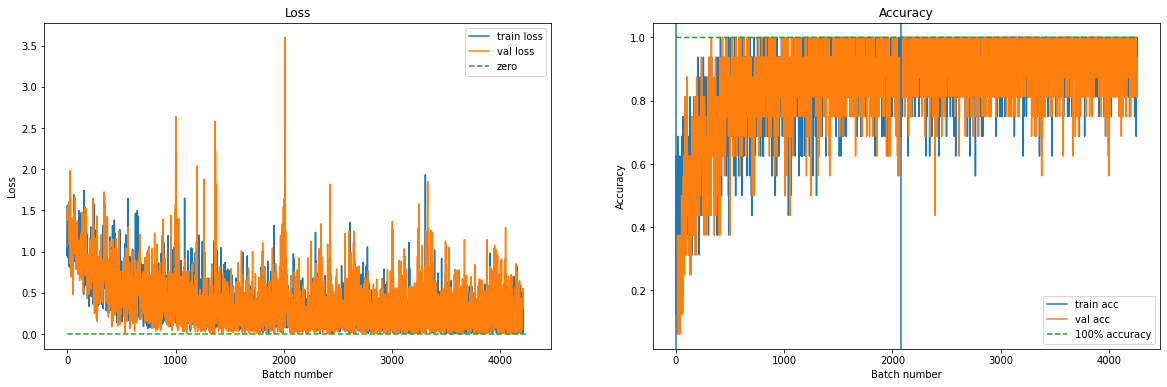

In [ ]:
epochs = 10

train_accs = []
test_accs = []

train_losses = []
test_losses = []

for epoch in range(epochs):
    for train in train_dataloader:
        model.train()
        data_train = train['image'].to(device)
        target_train = train['label'].to(device)

        optimizer.zero_grad()
        out_train = model(data_train.float())
        _, preds_train = torch.max(out_train, 1)
        train_loss = criterion(out_train, target_train)

        train_loss.backward()
        optimizer.step()
        
        test = next(iter(test_dataloader))
        model.eval()
        with torch.no_grad():
            data_test = test['image'].to(device)
            target_test = test['label'].to(device)
            out_test = model(data_test.float())
            _, preds_test = torch.max(out_test, 1)
            test_loss = criterion(out_test, target_test)

        train_accs.append(accuracy_score(train['label'], preds_train.cpu()))
        test_accs.append(accuracy_score(test['label'], preds_test.cpu()))
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        
        plot_progress(train_losses, train_accs, test_losses, test_accs)
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, f'weights/efficientnet_epoch_{epoch}.pt')

# Part 2. Image retrieval

In [ ]:
checkpoint = torch.load('weights/efficientnet_epoch_1.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [ ]:
model = torch.nn.Sequential(*(list(model.children())[:-1]))

In [ ]:
lst = []
for sample in tqdm(test_dataloader):
    out_test = model(sample['image'].to(device).float())
    out_test = torch.squeeze(out_test).detach().cpu().numpy()
    for i in range(len(sample['label'])):
        lst.append([sample['path'][i], sample['label'][i], out_test[i]])

100%|██████████| 236/236 [15:28<00:00,  3.94s/it]


In [ ]:
inv_mapper = {0: 'FLAIR', 1: 'T1w', 2: 'T1wCE', 3: 'T2w'}

## Euclidean distance

In [ ]:
n = len(lst)
results = np.zeros((n, n))
for i in tqdm(range(n)):
    for j in range(n):
        if lst[i][0].split('/')[1] == lst[j][0].split('/')[1]:
            results[i, j] = 1000000
        else:
            norm = np.linalg.norm(lst[i][2] - lst[j][2])
            results[i, j] = norm

100%|██████████| 3775/3775 [02:34<00:00, 24.50it/s]


In [ ]:
results_sorted = np.argsort(results)

In [ ]:
results_sorted

array([[1653, 1777, 1199, ..., 2684, 2622,    0],
       [ 254,  938, 2704, ..., 2852, 3432,  342],
       [ 790,  398, 2966, ..., 2670, 1679,  140],
       ...,
       [2152,  751, 1081, ..., 2900,  972, 1887],
       [ 507, 2138, 1500, ..., 3212, 3214,  287],
       [1130, 2719,  119, ..., 3434,  668, 3774]])

Accuracy for top-1 image:

In [ ]:
acc = 0
for i in tqdm(range(n)):
    if lst[i][1] == lst[results_sorted[i][0]][1]:
        acc += 1
print()
print(acc / n)

100%|██████████| 3775/3775 [00:00<00:00, 127713.19it/s]


0.9139072847682119


Accuracy for top-5 image:

In [ ]:
acc = 0
for i in tqdm(range(n)):
    for j in range(5):
        if lst[i][1] == lst[results_sorted[i][j]][1]:
            acc += 1
print()
print(acc / (5 * n))

100%|██████████| 3775/3775 [00:00<00:00, 33120.18it/s]


0.9080794701986755


## kNN

In [ ]:
p_test = {'00001', '00037', '00114'}
p_train = {'00125', '00163', '00190', '00229', '00662', '00762'}
X_train = np.array([i[2] for i in lst if i[0].split('/')[1] in p_train])
y_train = np.array([i[1].numpy() for i in lst if i[0].split('/')[1] in p_train])
X_test = np.array([i[2] for i in lst if i[0].split('/')[1] in p_test])
y_test = np.array([i[1].numpy() for i in lst if i[0].split('/')[1] in p_test])

k=5 neigbours

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

0.9456106870229007

k=3 neigbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

0.9437022900763359

k=1 neigbours

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

0.9389312977099237